In [34]:
def plot_endpoint_distribution(df, endpoint1, endpoint2, bySeverityCategory=False):
    """
    Plots histograms showing the distribution of specified endpoints for each device and compares the means.
    Optionally, plots the distribution by severity category.

    Parameters
    ----------
    df : DataFrame
        The original DataFrame containing the data.
            'VISIT': Visit name (e.g. VISIT2)
            'USUBJID': Unique subject ID
            'digital_EP': Endpoint name (e.g. WASO, AHI, etc.)
            'digital_EP_value': Endpoint value (some numeric value)
            'digital_EP_severity_category': Severity category of the endpoint
            'COHORT': Treatment group (e.g. Placebo/ Treatment)
            'DEVICE': Device name (e.g. WatchPAT, PSG, etc.)
    endpoint1 : str
        The first endpoint to plot (e.g., WASO, AHI, etc.).
    endpoint2 : str
        The second endpoint to plot (e.g., WASO, AHI, etc.).
    bySeverityCategory : bool, optional
        Whether to plot the distribution by severity category.

    Returns
    ----------
    None
    """
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from scipy.stats import ttest_ind
    import numpy as np
    
    def get_visit_number(visit):
        """
        Extracts the numeric part of the visit name for sorting.
        Non-numeric visits are considered invalid and return None.
        """
        import re
        match = re.match(r'^VISIT(\d+)$', visit, re.IGNORECASE)
        if match:
            return int(match.group(1))
        elif visit.lower() == 'screening':
            return 0
        else:
            return None

    # Filter the DataFrame for the specified endpoints
    df_endpoint1 = df[df['digital_EP'] == endpoint1]
    df_endpoint2 = df[df['digital_EP'] == endpoint2]

    if bySeverityCategory:
        # Get the unique severity categories
        severity_categories = df['digital_EP_severity_category'].unique()
        series = pd.Series(severity_categories)

        # Drop NaN values
        clean_series = series.dropna()

        # Convert back to NumPy array if needed
        severity_categories = clean_series.values

        for category in severity_categories:
            category_data1 = df_endpoint1[df_endpoint1['digital_EP_severity_category'] == category]
            category_data2 = df_endpoint2[df_endpoint2['digital_EP_severity_category'] == category]

            plt.figure(figsize=(12, 8))
            sns.histplot(data=category_data1, x='digital_EP_value', bins=20, kde=True, color='blue', label=endpoint1)
            sns.histplot(data=category_data2, x='digital_EP_value', bins=20, kde=True, color='green', label=endpoint2, alpha=0.5)

            subject_count1 = category_data1['USUBJID'].nunique()
            subject_count2 = category_data2['USUBJID'].nunique()
            plt.title(f'Distribution of {endpoint1} and {endpoint2} by Severity Category: {category} ({subject_count1} and {subject_count2} subjects)')
            plt.xlabel('Endpoint Value')
            plt.ylabel('Count')
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        # Filter out invalid visits
        df_endpoint1['visit_num'] = df_endpoint1['VISIT'].apply(get_visit_number)
        df_endpoint2['visit_num'] = df_endpoint2['VISIT'].apply(get_visit_number)
        df_endpoint1 = df_endpoint1.dropna(subset=['visit_num'])
        df_endpoint2 = df_endpoint2.dropna(subset=['visit_num'])

        # Ensure visit_num is integer type
        df_endpoint1['visit_num'] = df_endpoint1['visit_num'].astype(int)
        df_endpoint2['visit_num'] = df_endpoint2['visit_num'].astype(int)

        # Identify visits where data for both endpoints is available
        visits = set(df_endpoint1['VISIT'].unique()).intersection(df_endpoint2['VISIT'].unique())
        statistics = []

        for visit in visits:
            visit_data1 = df_endpoint1[df_endpoint1['VISIT'].str.lower() == visit.lower()]
            visit_data2 = df_endpoint2[df_endpoint2['VISIT'].str.lower() == visit.lower()]

            if visit_data1.empty or visit_data2.empty:
                continue

            fig, axs = plt.subplots(1, 2, figsize=(16, 6))

            sns.histplot(data=visit_data1, x='digital_EP_value', bins=20, kde=True, ax=axs[0], color='blue')
            sns.histplot(data=visit_data2, x='digital_EP_value', bins=20, kde=True, ax=axs[1], color='green')

            axs[0].set_title(f'{endpoint1} values in {visit}', fontsize=15)
            axs[1].set_title(f'{endpoint2} values in {visit}', fontsize=15)
            axs[0].set_xlabel(f'{endpoint1} Value', fontsize=12)
            axs[1].set_xlabel(f'{endpoint2} Value', fontsize=12)
            axs[0].set_ylabel('Frequency', fontsize=12)
            axs[1].set_ylabel('Frequency', fontsize=12)
            axs[0].grid(axis='y', alpha=0.75)
            axs[1].grid(axis='y', alpha=0.75)

            plt.suptitle(f'Distribution of {endpoint1} and {endpoint2} values in {visit}', fontsize=18)

            mean1 = visit_data1['digital_EP_value'].mean()
            mean2 = visit_data2['digital_EP_value'].mean()
            t_stat, p_value = ttest_ind(visit_data1['digital_EP_value'], visit_data2['digital_EP_value'])

            if p_value < 0.05:
                conclusion = f'There is a statistically significant difference between {endpoint1} and {endpoint2} in {visit} (p < 0.05).'
            else:
                conclusion = f'There is no statistically significant difference between {endpoint1} and {endpoint2} in {visit} (p >= 0.05).'

            statistics.append({
                'Visit': visit,
                f'{endpoint1} Mean': mean1,
                f'{endpoint2} Mean': mean2,
                'p-value': p_value,
                'Conclusion': conclusion
            })

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

        # Create a DataFrame from the statistics and display it
        stats_df = pd.DataFrame(statistics)
        print(stats_df)
        for conclusion in stats_df['Conclusion']:
            print(conclusion)

# Example usage:
# df = pd.read_csv("../data/standardized_analysis_ready_df-1.csv")
# plot_endpoint_distribution(df, 'AHI', 'PAHI', False)


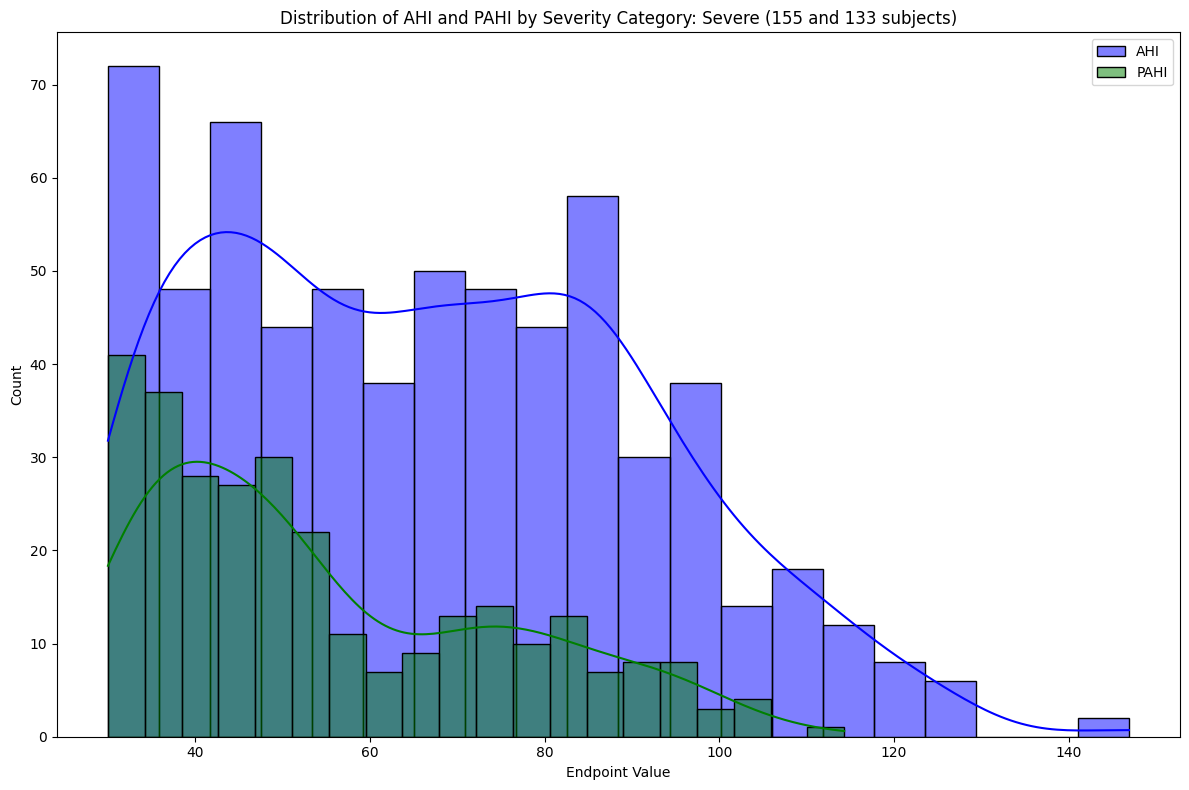

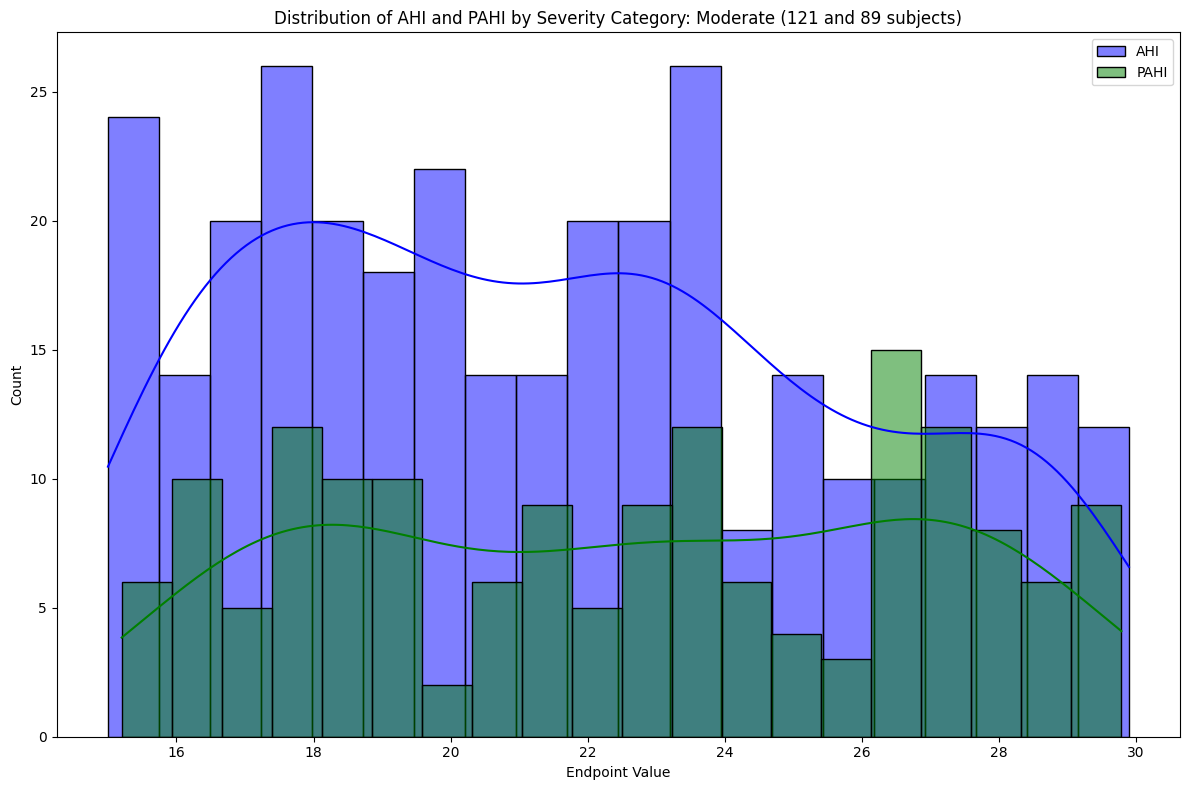

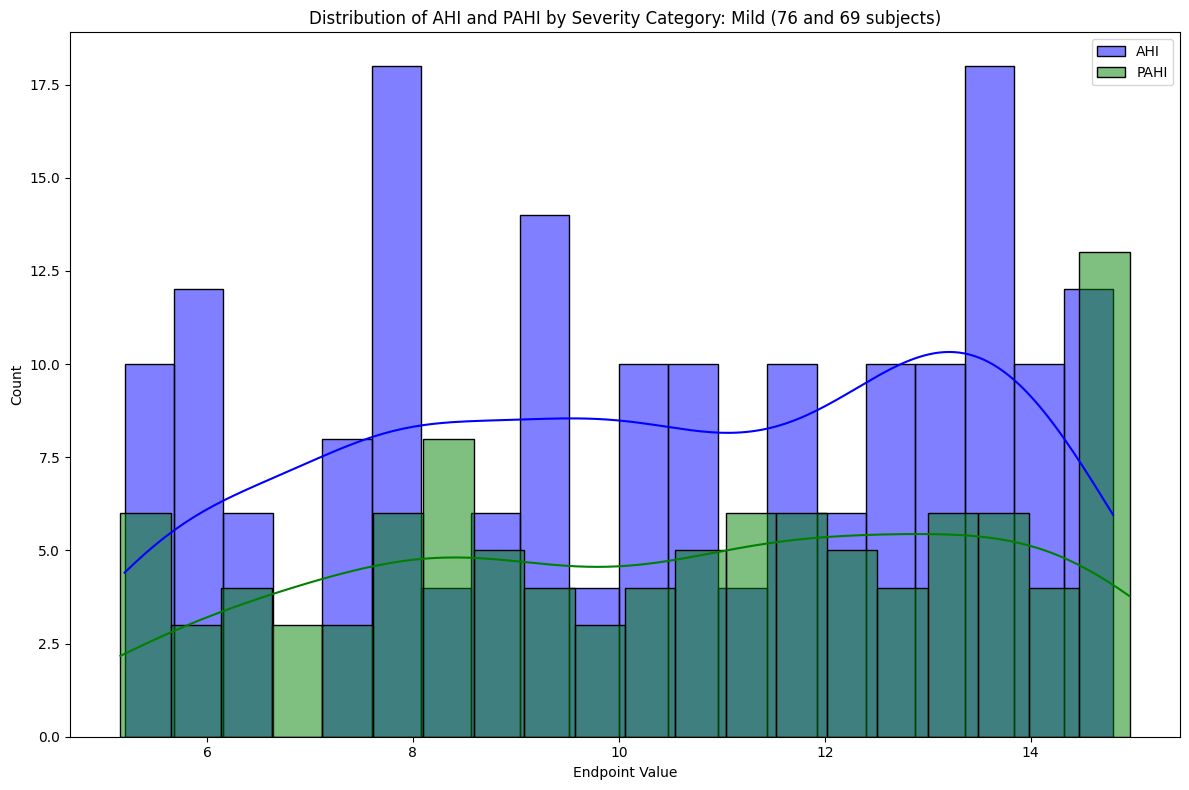

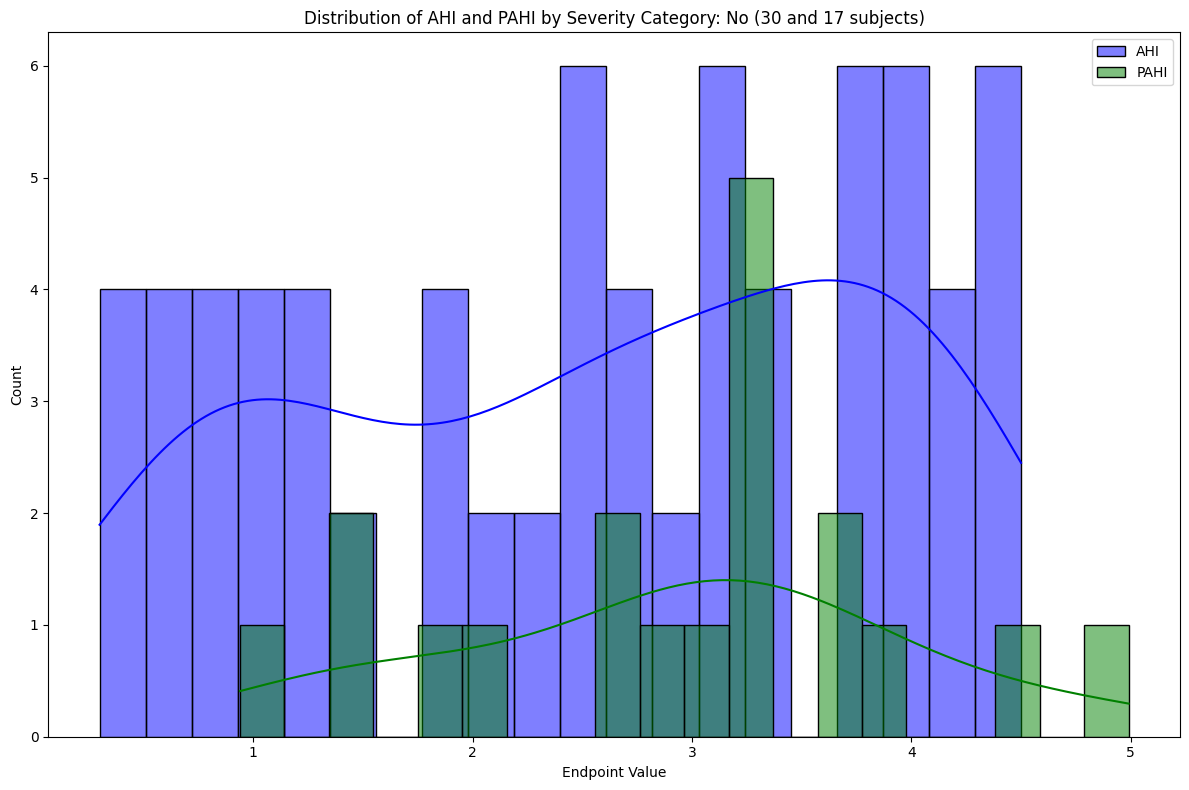

In [35]:
import pandas as pd
df = pd.read_csv("../data/standardized_analysis_ready_df-1.csv")
plot_endpoint_distribution(df, 'AHI', 'PAHI', True)

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import linregress, spearmanr, pearsonr

def plot_correlation(df, endpoint1, endpoint2, bySeverityCategory=False):
    """
    Plots scatter plots showing the correlation between two endpoints for each device.
    Optionally, plots the correlation by severity category.

    Parameters
    ----------
    df : DataFrame
        The original DataFrame containing the data.
            'VISIT': Visit name (e.g. VISIT2)
            'USUBJID': Unique subject ID
            'digital_EP': Endpoint name (e.g. WASO, AHI, etc.)
            'digital_EP_value': Endpoint value (some numeric value)
            'digital_EP_severity_category': Severity category of the endpoint
            'COHORT': Treatment group (e.g. Placebo/ Treatment)
            'DEVICE': Device name (e.g. WatchPAT, PSG, etc.)
    endpoint1 : str
        The first endpoint to compare (e.g., WASO).
    endpoint2 : str
        The second endpoint to compare (e.g., AHI).
    bySeverityCategory : bool, optional
        Whether to plot the correlation by severity category.

    Returns
    ----------
    None
    """

    # Filter the DataFrame for the specified endpoints
    df_endpoint1 = df[df['digital_EP'] == endpoint1]
    df_endpoint2 = df[df['digital_EP'] == endpoint2]

    # Merge the data for both endpoints to include only subjects with data for both
    common_subjects = pd.merge(
        df_endpoint1[['USUBJID', 'VISIT', 'digital_EP_value', 'digital_EP_severity_category']],
        df_endpoint2[['USUBJID', 'VISIT', 'digital_EP_value', 'digital_EP_severity_category']],
        on=['USUBJID', 'VISIT', 'digital_EP_severity_category'],
        suffixes=(f'_{endpoint1}', f'_{endpoint2}')
    )

    # Check if there is data to plot
    if common_subjects.empty:
        print("No overlapping data between the specified endpoints/devices.")
        return "No overlapping data to plot."

    def create_plot(x, y, title, xlabel, ylabel):
        # Calculate the correlation coefficients and line of best fit
        slope, intercept, r_value, p_value, std_err = linregress(x, y, alternative="two-sided")
        line = slope * x + intercept
        spearman_corr, spearman_p_value = spearmanr(x, y)
        pearson_corr, pearson_p_value = pearsonr(x, y)

        # Create the scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=x, y=y)
        plt.plot(x, line, color='red', label=f'Line of Best Fit: y={slope:.2f}x+{intercept:.2f}')
        plt.title(f'{title}\n'
                  f'Spearman Correlation: {spearman_corr:.2f}\n       '
                  f'Pearson Correlation: {pearson_corr:.2f}\n p-value: {pearson_p_value:.4f}')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if bySeverityCategory:
        # Get the unique severity categories
        severity_categories = common_subjects['digital_EP_severity_category'].unique()

        # Create a plot for each severity category
        for category in severity_categories:
            category_data = common_subjects[common_subjects['digital_EP_severity_category'] == category]

            x = category_data[f'digital_EP_value_{endpoint1}']
            y = category_data[f'digital_EP_value_{endpoint2}']

            create_plot(x, y,
                        f'{endpoint1} vs {endpoint2} Correlation\nSeverity Category: {category}',
                        f'{endpoint1} Value', f'{endpoint2} Value')
    else:
        x = common_subjects[f'digital_EP_value_{endpoint1}']
        y = common_subjects[f'digital_EP_value_{endpoint2}']

        create_plot(x, y,
                    f'{endpoint1} vs {endpoint2} Correlation',
                    f'{endpoint1} Value', f'{endpoint2} Value')

# Example usage:
# df = pd.read_csv("../data/standardized_analysis_ready_df-1.csv")
# plot_correlation(df, 'AHI', 'PAHI', True)


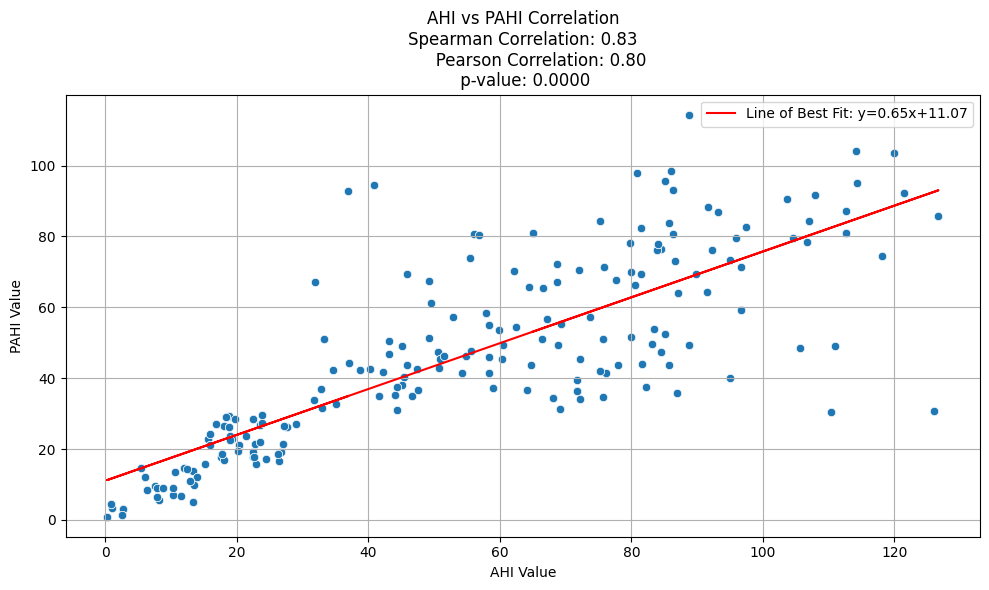

In [45]:

df = pd.read_csv("../data/standardized_analysis_ready_df-1.csv")
plot_correlation(df, 'AHI', 'PAHI', False)


In [46]:
def severity_category_confusion_matrix(df, endpoint, visit1='Screening', visit2=None):
    """
    Generates confusion matrices for severity categories of an endpoint between two visits for each treatment cohort.

    Parameters
    ----------
    df : DataFrame
        The original DataFrame containing the data.
            'VISIT': Visit name (e.g. VISIT2)
            'USUBJID': Unique subject ID
            'digital_EP': Endpoint name (e.g. WASO, AHI, etc.)
            'digital_EP_severity_category': Severity category of the endpoint
            'COHORT': Treatment group (e.g. Placebo/ Treatment)
            'DEVICE': Device name (e.g. WatchPAT, PSG, etc.)
    endpoint : str
        The endpoint to analyze (e.g., WASO, AHI, etc.).
    visit1 : str, optional
        The first visit to compare (default is 'Screening').
    visit2 : str, optional
        The second visit to compare (default is the latest valid visit).

    Returns
    ----------
    None
    """
    
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Determine the latest visit if visit2 is not specified
    if visit2 is None:
        visits = df['VISIT'].str.extract(r'(\d+)', expand=False).dropna().astype(int)
        latest_visit_num = visits.max()
        visit2 = f'VISIT{latest_visit_num}'

    # Filter the DataFrame for the specified endpoint
    df_filtered = df[df['digital_EP'] == endpoint]

    # Get the unique treatment cohorts
    cohorts = df_filtered['COHORT'].unique()

    # Define the order of severity categories
    severity_order = ['Severe', 'Moderate', 'Mild', 'No']

    for cohort in cohorts:
        df_cohort = df_filtered[df_filtered['COHORT'] == cohort]

        # Filter data for visit1 and visit2
        df_visit1 = df_cohort[df_cohort['VISIT'].str.lower() == visit1.lower()][['USUBJID', 'digital_EP_severity_category']]
        df_visit2 = df_cohort[df_cohort['VISIT'].str.lower() == visit2.lower()][['USUBJID', 'digital_EP_severity_category']]

        # Rename columns to avoid confusion when merging
        df_visit1 = df_visit1.rename(columns={'digital_EP_severity_category': f'severity_category_{visit1}'})
        df_visit2 = df_visit2.rename(columns={'digital_EP_severity_category': f'severity_category_{visit2}'})

        # Merge the two visits on USUBJID
        df_merged = pd.merge(df_visit1, df_visit2, on='USUBJID')

        if df_merged.empty:
            print(f"No overlapping data between {visit1} and {visit2} for cohort {cohort}.")
            continue

        # Generate the confusion matrix
        y_true = pd.Categorical(df_merged[f'severity_category_{visit1}'], categories=severity_order, ordered=True)
        y_pred = pd.Categorical(df_merged[f'severity_category_{visit2}'], categories=severity_order, ordered=True)

        cm = pd.crosstab(y_true, y_pred, rownames=[f'Severity Category at {visit1}'], colnames=[f'Severity Category at {visit2}'], dropna=False)

        if cm.empty:
            print(f"No data to plot for cohort {cohort}.")
            continue

        # Calculate percentages
        cm_percentage = cm.div(cm.sum(axis=1), axis=0) * 100

        # Create annotations with counts and percentages
        annot = cm.astype(str) + "\n" + cm_percentage.round(2).astype(str) + '%'

        # Plot the confusion matrix
        plt.figure(figsize=(10, 7))
        ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=severity_order, yticklabels=severity_order, cbar=False)
        plt.xlabel(f'Severity Category at {visit2}')
        plt.ylabel(f'Severity Category at {visit1}')
        plt.title(f'Confusion Matrix of Severity Categories for {endpoint}\nCohort: {cohort}')
        ax.xaxis.set_ticks_position('top')
        plt.xticks(rotation=45)
        plt.show()

# Example usage:
# df = pd.read_csv("../data/standardized_analysis_ready_df-1.csv")
# severity_category_confusion_matrix(df, 'AHI', 'Screening', 'VISIT2')


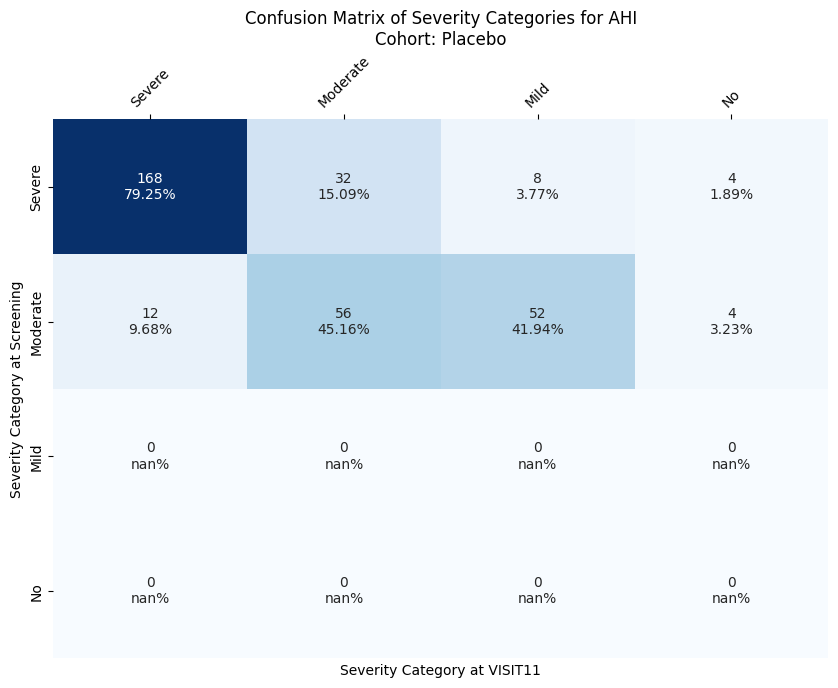

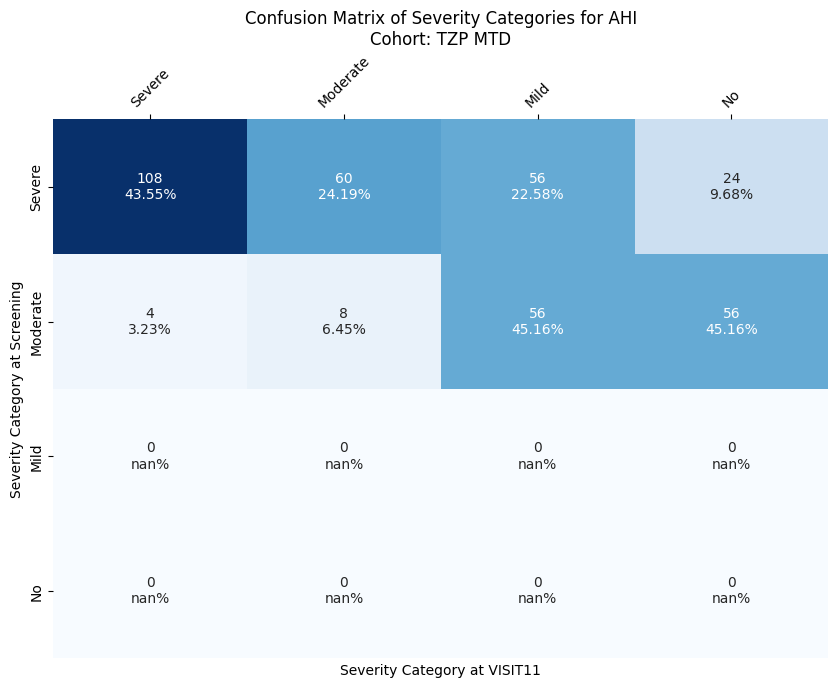

In [48]:
df = pd.read_csv("../data/standardized_analysis_ready_df-1.csv")
severity_category_confusion_matrix(df, 'AHI', 'Screening')

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def categorized_strip_plot(df, endpoint, gold_standard_endpoint, visit=None):
    """
    Creates categorized strip plots for each device to visualize incorrect classifications compared to a gold standard device.

    Parameters
    ----------
    df : DataFrame
        The original DataFrame containing the data.
            'VISIT': Visit name (e.g. VISIT2)
            'USUBJID': Unique subject ID
            'digital_EP': Endpoint name (e.g. WASO, AHI, etc.)
            'digital_EP_value': Endpoint value (some numeric value)
            'digital_EP_severity_category': Severity category of the endpoint
            'COHORT': Treatment group (e.g. Placebo/ Treatment)
            'DEVICE': Device name (e.g. WatchPAT, PSG, etc.)
    endpoint : str
        The endpoint to analyze (e.g., WASO, AHI, etc.).
    gold_standard_endpoint : str
        The gold standard endpoint to compare against.
    visit : str, optional
        The visit to filter the data (default is to use all visits).

    Returns
    ----------
    None
    """
    
    # Define severity order
    severity_order = ['No', 'Mild', 'Moderate', 'Severe']
    
    # Filter the DataFrame for the specified endpoint and visit
    df_filtered = df[(df['digital_EP'] == endpoint) | (df['digital_EP'] == gold_standard_endpoint)]
    
    if visit:
        df_filtered = df_filtered[df_filtered['VISIT'].str.lower() == visit.lower()]

    # Pivot the DataFrame to compare endpoints
    df_pivot = df_filtered.pivot_table(index='USUBJID', columns='digital_EP', values='digital_EP_severity_category', aggfunc='first')

    # Check if both endpoints are in the DataFrame
    if endpoint not in df_pivot.columns or gold_standard_endpoint not in df_pivot.columns:
        print(f"Both {endpoint} and {gold_standard_endpoint} must be present in the DataFrame.")
        return
    
    # Create a DataFrame for plotting
    plot_df = df_pivot[[gold_standard_endpoint, endpoint]].dropna().reset_index()
    plot_df['Severity'] = plot_df[gold_standard_endpoint]
    
    # Create the strip plot for the gold standard endpoint
    plt.figure(figsize=(12, 8))
    sns.stripplot(x=gold_standard_endpoint, y='USUBJID', data=plot_df, order=severity_order, palette='deep', size=8, alpha=0.6, jitter=False)
    
    # Create the strip plot for the specified endpoint, using hue to differentiate severity categories
    sns.stripplot(x=endpoint, y='USUBJID', data=plot_df, order=severity_order, hue='Severity', size=6, alpha=0.6, dodge=True, palette='deep', jitter=True)
    
    plt.xlabel(f'True Severity Category ({gold_standard_endpoint})')
    plt.ylabel('Subjects')
    plt.title(f'Misclassification of {endpoint} compared to {gold_standard_endpoint}, Visit: {visit if visit else "All"}')
    plt.legend(title=f'{endpoint} Severity Category', bbox_to_anchor=(1.05, 1), loc='upper left', labels=severity_order, handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in sns.color_palette('deep', len(severity_order))])
    plt.tight_layout()
    plt.show()

# Example usage:
# df = pd.read_csv("../data/standardized_analysis_ready_df-1.csv")
# categorized_strip_plot(df, 'AHI', 'PSG_AHI', 'VISIT2')


/var/folders/s0/pn04f99n6zn_4z2p6kb40fv40000gn/T/ipykernel_58289/591581016.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=gold_standard_endpoint, y='USUBJID', data=plot_df, order=severity_order, palette='deep', size=8, alpha=0.6, jitter=False)


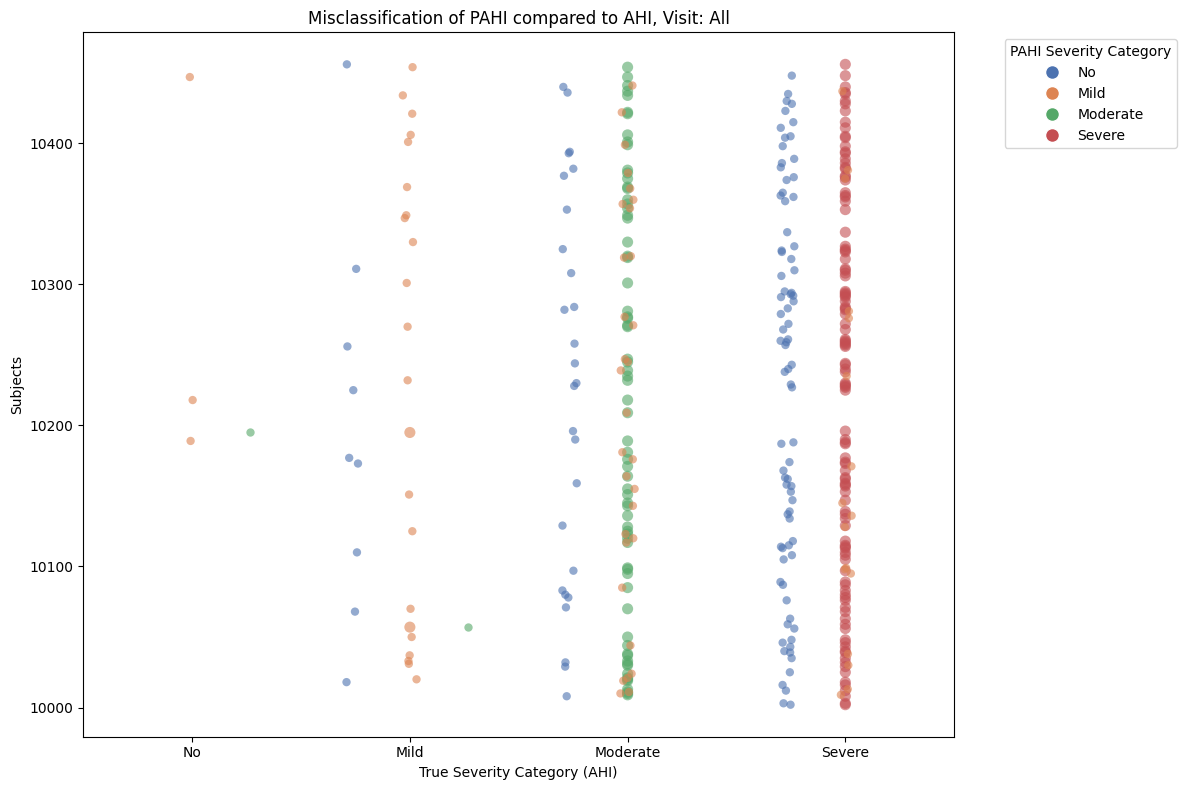

In [53]:
categorized_strip_plot(df, 'PAHI', 'AHI', visit=None)